In [1]:
# Import libaries and illustris library
import numpy as np
import illustris_python as il
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import gridspec
%matplotlib inline
import random
import subroutines.bins as bf
import subroutines.plot_functions as plot_functions
hubble = 0.704

In [2]:
plt.style.use('default')
mpl.use('pdf')
mpl.rcParams['lines.linewidth']=2
mpl.rcParams['font.size']=15
%load_ext autoreload 
%autoreload 2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# everything in units of h! (h= 0.7)

In [3]:
snaps=[135,116,103,85]
galData = []
webData = []
for i in snaps:
    # 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
    # 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
    # 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda, 18:BHMass 19:BMMassDot 20:StarFormationRate (MDot) 21:N(sub_z=0) 22:N(sub_z_next) 23:N(sub_z_previous)
    galData.append(np.genfromtxt('../../Data/GalaxyData/GalaxyData_Snap.'+str(i)+'.txt'))

    # 0:HaloNumber, 1:SubhaloNumber, 2-4:SubhaloPosition x,y,z, 5: Index of nearest critical point, 6: absolute distance to crit., 7-9: nearest critical point coordinates, 
    # 10: Index of nearest filament, 11:absolute distance to filament, 12-14: nearest filament coordinates, 15: cos(theta) 16:sin(theta)
    # 17: cluster=1, filament=0, none=-1
    webData.append(np.genfromtxt('../../Data/WebData/galaxy_web_data.'+str(i)+'.txt'))

In [60]:
def maskEllips(whichSnap):
    return (galData[whichSnap][:,14]<0.5)
def maskMass(whichSnap, mass):
    return (galData[whichSnap][:,2]>mass)

# bins is bin list, value means filament or cluster (0 or 1), mass means mass cutoff, indices are which to bin
def fractions_function(bins_1, bins_2, value, mass = 11, index1=17, index2=17):
    if (mass == 0):
        fractions = [];
        for i in range (0,4):
            fractions.append( bf.bin_frac(webData[i][maskEllips(i)][:,index1],
                                      galData[i][maskEllips(i)][:,index2], bins_1, value)
                            )
    else:
        fractions = [[],[]]
        for i in range (0,4):
            # first mass below variable mass
            fractions[0].append( bf.bin_frac(webData[i][maskEllips(i) & (~maskMass(i,mass))][:,index1],
                                          galData[i][maskEllips(i) & (~maskMass(i,mass))][:,index2], bins_1, value)
                                )
            # then above
            fractions[1].append(bf.bin_frac(webData[i][maskEllips(i) & (maskMass(i,mass))][:,index1],
                                          galData[i][maskEllips(i) & (maskMass(i,mass))][:,index2], bins_2, value)
                                )
    return fractions;

def redshift_fractions(bcluster=1):
    frac_z = np.zeros((2,2,4))
    for i in range (0,4):
        frac_z[0,:,i] = bf.find_frac(webData[i][maskEllips(i) & (~maskMass(i,11))][:,17],bcluster)[:]
        frac_z[1,:,i] = bf.find_frac(webData[i][maskEllips(i) & (maskMass(i,11))][:,17],bcluster)[:]
    return frac_z

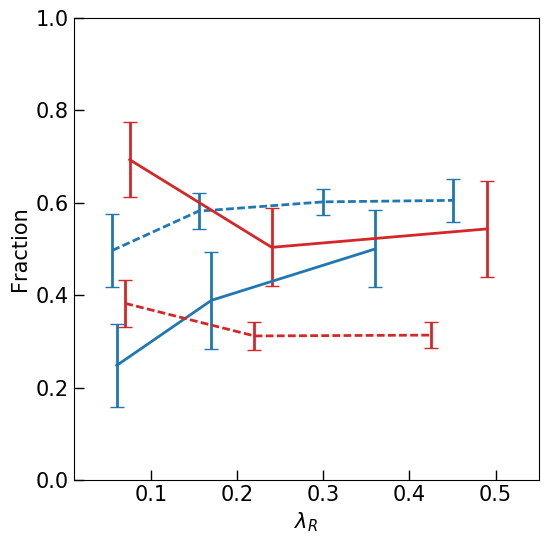

In [140]:
# fraction of ellipcials in filaments (blue) and clusters (red) with mass cutoff at 10^11 M*/M, below that mass dotted, above continuous at z=0
fil_bins_b11 = [0.0,0.11,0.2,0.4,0.5]; fil_bins_a11 = [0.0,0.12,0.22,0.5]; bins_b11 = [0.0,0.14,0.3,0.55]#[0.0,0.13,0.25,0.4,0.5];
bins_a11 = [0.0,0.15,0.33,0.65]#[0.0,0.13,0.25,0.5]#[0.0,0.175,0.25,0.5]
fil_frac = fractions_function(fil_bins_b11,fil_bins_a11,0); clust_frac = fractions_function(bins_b11, bins_a11,1);
fig = plt.figure(figsize=(6, 6));gs=gridspec.GridSpec(1, 1);
for i in [0]:
    ax1 = plt.subplot(gs[0,0], facecolor='white'); #ax2 = plt.subplot(gs[0,1], sharex=ax1, sharey=ax1);
    
    ax1.errorbar(fil_frac[1][i][:,0],fil_frac[1][i][:,1], yerr=fil_frac[1][i][:,2], fmt='-', label='Ellipitc galaxies $M_* >10^{11} M_\odot$', capsize=5,color='C0')
    ax1.errorbar(fil_frac[0][i][:,0],fil_frac[0][i][:,1], yerr=fil_frac[0][i][:,2], fmt='--', label='Ellipitc galaxies $M_* <10^{11} M_\odot$', capsize=5,color='C0')
    
    ax1.errorbar(clust_frac[1][i][:,0],clust_frac[1][i][:,1], yerr=clust_frac[1][i][:,2], fmt='-', label='Ellipitc galaxies $M_* >10^{11} M_\odot$', capsize=5,color='C3')
    ax1.errorbar(clust_frac[0][i][:,0],clust_frac[0][i][:,1], yerr=clust_frac[0][i][:,2], fmt='--', label='Ellipitc galaxies $M_* <10^{11} M_\odot$', capsize=5,color='C3')
    ax1.xaxis.set_tick_params(width=1, length=7, direction='in');ax1.yaxis.set_tick_params(width=1, length=7, direction='in');
    handles, labels = ax1.get_legend_handles_labels(); handles = [h[0] for h in handles];
ax1.set_xlabel(r'$\lambda_R$'); ax1.set_ylabel('Fraction');ax1.set_ylim([0, 1]);ax1.set_xlim([0.01, 0.55]);

In [6]:
absolute_clus = [[],[]]; absolute_fil = [[],[]];
for i in range (0,4):
    absolute_clus[0].append(webData[i][(webData[i][:,17]==1) & maskEllips(i) & (~maskMass(i,11))].shape[0])
    absolute_fil[0].append(webData[i][(webData[i][:,17]==0) & maskEllips(i) & (~maskMass(i,11))].shape[0])
    absolute_clus[1].append(webData[i][(webData[i][:,17]==1) & maskEllips(i) & (maskMass(i,11))].shape[0])
    absolute_fil[1].append(webData[i][(webData[i][:,17]==0) & maskEllips(i) & (maskMass(i,11))].shape[0])
print(absolute_clus,absolute_fil)

[[892, 805, 718, 400], [225, 242, 197, 123]] [[1683, 1429, 1169, 816], [148, 57, 58, 29]]


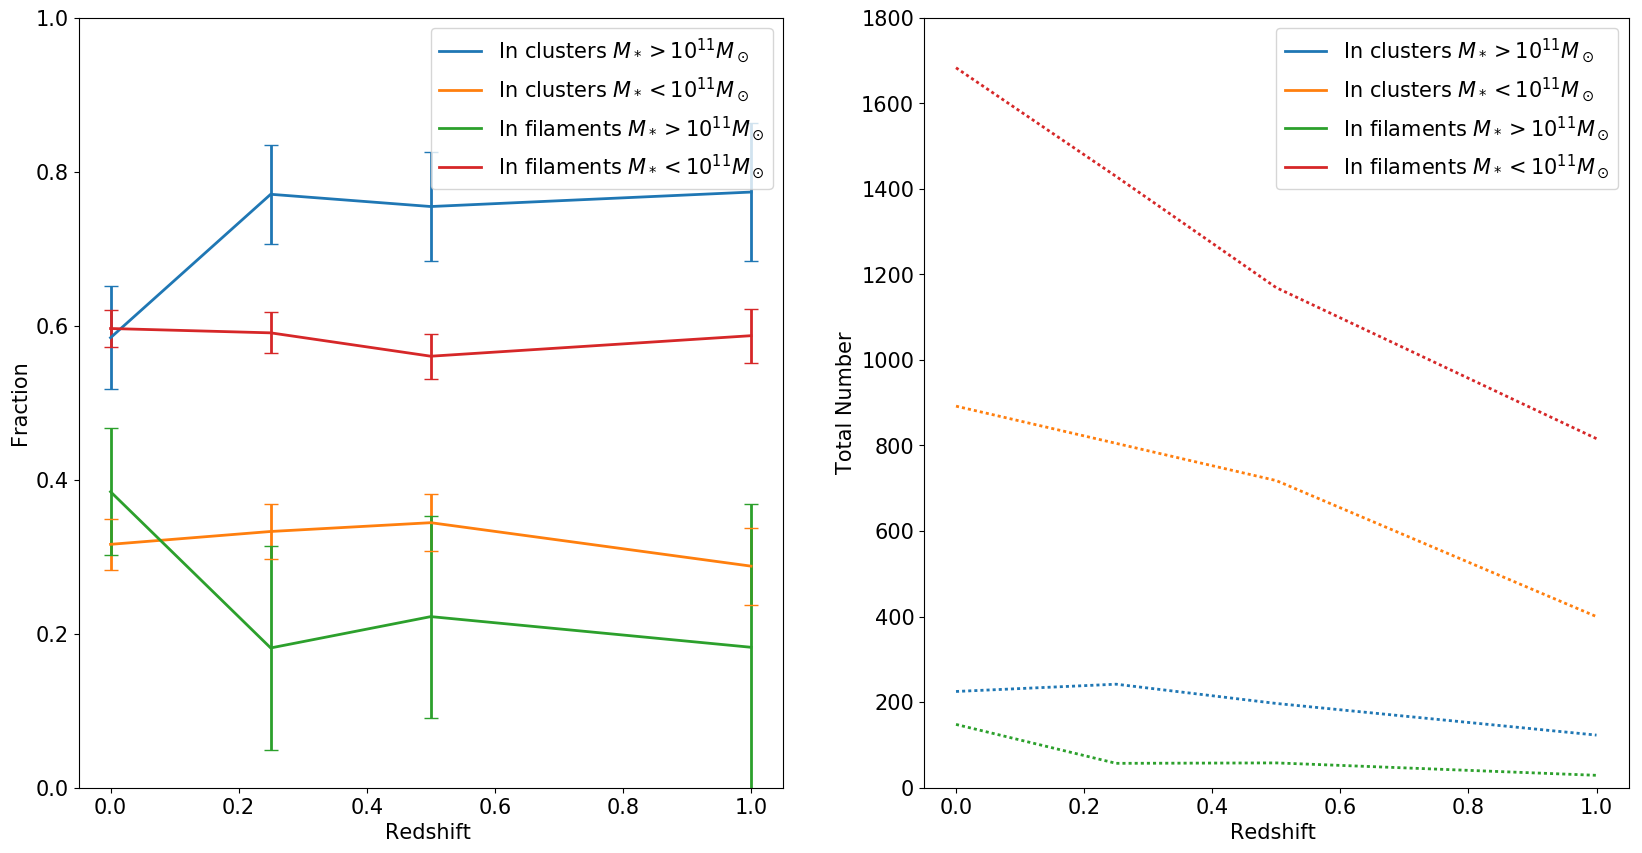

In [7]:
#Ellipitc galaxies fractions and total number per redshift
redshift = [0,0.25,0.50,1]
clust_frac_z = redshift_fractions()
fil_frac_z = redshift_fractions(0)

fig = plt.figure(figsize=(20, 10)); gs=gridspec.GridSpec(1,2); ax3=plt.subplot(gs[0,0]);ax4=plt.subplot(gs[0,1]);

ax3.errorbar(redshift[:], clust_frac_z[1][0][:], yerr=clust_frac_z[1][1][:], fmt='-', label='In clusters $M_* >10^{11} M_\odot$', capsize=5)
ax3.errorbar(redshift[:], clust_frac_z[0][0][:], yerr=clust_frac_z[0][1][:], fmt='-', label='In clusters $M_* <10^{11} M_\odot$', capsize=5)

ax3.errorbar(redshift[:], fil_frac_z[1][0][:], yerr=fil_frac_z[1][1][:], fmt='-', label='In filaments $M_* >10^{11} M_\odot$', capsize=5)
ax3.errorbar(redshift[:], fil_frac_z[0][0][:], yerr=fil_frac_z[0][1][:], fmt='-', label='In filaments $M_* <10^{11} M_\odot$', capsize=5)

#ax4 = ax3.twinx();
ax4.set_ylim([0, 1800]);
ax4.plot(redshift, absolute_clus[1], label='clusters $M_* >10^{11} M_\odot$',linestyle=':'); ax4.plot(redshift, absolute_clus[0], label='clusters $M_* <10^{11} M_\odot$',linestyle=':'); 
ax4.plot(redshift, absolute_fil[1], label='filaments $M_* >10^{11} M_\odot$',linestyle=':'); ax4.plot(redshift, absolute_fil[0], label='filaments $M_* <10^{11} M_\odot$',linestyle=':');

handles, labels = ax3.get_legend_handles_labels(); handles = [h[0] for h in handles];
ax3.legend(handles,labels,loc="upper right"); ax3.set_xlabel('Redshift '); ax3.set_ylabel('Fraction'); ax3.set_ylim([0, 1]);
ax4.set_xlabel('Redshift '); ax4.set_ylabel('Total Number');ax4.legend(handles,labels,loc="upper right");

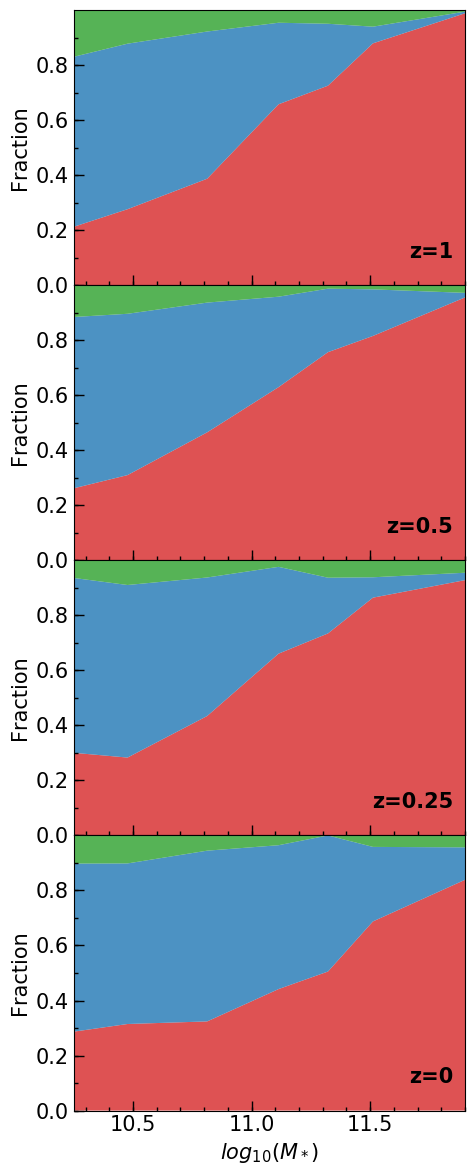

In [142]:
# red is cluster fraction, blue is filaments, green is out, all for !!elliptical galaxies
bins = [1.5,2,4,9,17,25,40,135]
frac_fil = fractions_function(bins, [1], 0, 0, index1=17, index2=2)
frac_clus = fractions_function(bins,[1], 1, 0, index1=17, index2=2)
fig = plt.figure(figsize=(5, 12)); gs=gridspec.GridSpec(4, 1);

for i in [3,2,1,0]:   
    ax = plt.subplot(gs[3-i,0], facecolor='white');
    ax.fill_between(np.log10(frac_fil[i][:,0]*10**10),0,frac_clus[i][:,1],facecolor='C3',alpha=0.8)
    ax.fill_between(np.log10(frac_fil[i][:,0]*10**10),frac_clus[i][:,1],frac_fil[i][:,1]+frac_clus[i][:,1],facecolor='C0',alpha=0.8)
    ax.fill_between(np.log10(frac_fil[i][:,0]*10**10),frac_fil[i][:,1]+frac_clus[i][:,1],1,facecolor='C2',alpha=0.8)
    
    handles, labels = ax1.get_legend_handles_labels(); handles = [h[0] for h in handles];
    ax.text(11.85,0.1, 'z='+str(redshift[i]),fontsize=15, fontweight='bold', ha='right'); ax.set_ylabel('Fraction');
    ax.xaxis.set_ticks(np.arange(10, 12, 0.5)); ax.yaxis.set_ticks(np.arange(0, 0.9, 0.2))
    minor_ticks_x = np.arange(10, 12, 0.1); ax.set_xticks(minor_ticks_x, minor=True); ax.xaxis.set_tick_params(which='minor',width=1, length=3, direction='in');                                  
    minor_ticks_y = np.arange(0, 1, 0.1); ax.set_yticks(minor_ticks_y, minor=True); ax.yaxis.set_tick_params(which='minor',width=1, length=3, direction='in');
    ax.set_xlim([10.25, 11.9]);ax.set_ylim([0.0, 1]);
    ax.xaxis.set_tick_params(width=1, length=7, direction='in'); ax.yaxis.set_tick_params(width=1, length=7, direction='in');

ax.xaxis.set_tick_params(width=1, length=7, direction='in'); ax.set_xlabel('$log_{10}(M_*)$'); ax.set_ylim([0.0, 1]);
plt.tight_layout(); plt.subplots_adjust(hspace=0, wspace=.0); plt.show()

m

In [252]:
# look at filament alignment
log_bin_theta=[];
theta_bins = [[1,3,5,8,25],[]]
for i in [0]:
    log_bin_theta.append(bf.bin_data(galData[i][ maskEllips(i) & (webData[i][:,17]==0)][:,2], 
                                         webData[i][ maskEllips(i) & (webData[i][:,17]==0) ][:,15],theta_bins[i],1)
                         )

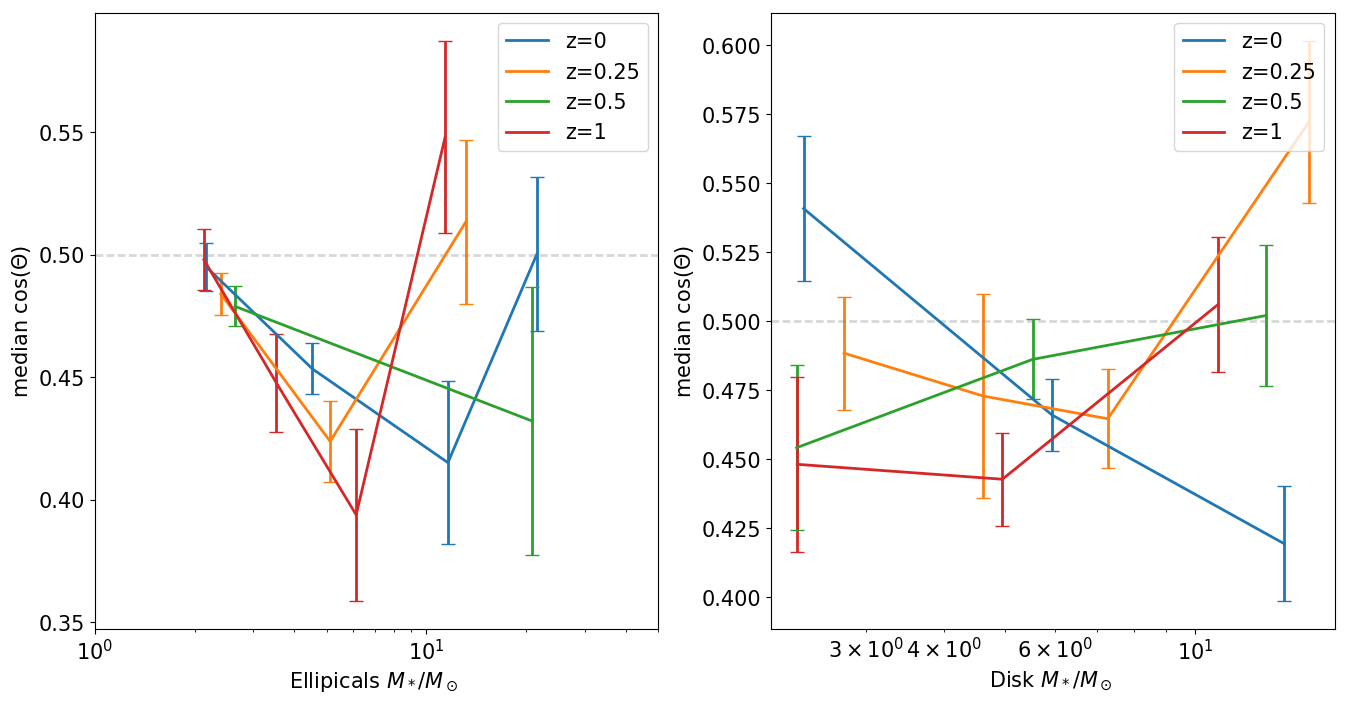

In [494]:
log_bin_theta=[]; theta_bins =[[0,3,10,15,65],[0,4,9,65],[0,15,65],[0,3,5,8,65]];
disk_bin=[]; disk_bins = [[0,3,10,60],[0,4,5,12,60],[0,3,10,60],[0,3,8,60]];
fig = plt.figure(figsize=(16, 8)); gs=gridspec.GridSpec(1,2); ax5=plt.subplot(gs[0,0]);ax6=plt.subplot(gs[0,1]);
for i in [0,1,2,3]:
    log_bin_theta.append(bf.bin_data(galData[i][ maskEllips(i) & (webData[i][:,17]==0)][:,2], abs(webData[i][ maskEllips(i) & (webData[i][:,17]==0) ][:,15]),theta_bins[i],1))
    ax5.errorbar(log_bin_theta[i][:,0], (log_bin_theta[i][:,1]), yerr=log_bin_theta[i][:,3], fmt='-', label='z='+str(redshift[i]), capsize=5)
    
    disk_bin.append(bf.bin_data(galData[i][ (~maskEllips(i)) & (webData[i][:,17]==0)][:,2], abs(webData[i][ (~maskEllips(i)) & (webData[i][:,17]==0) ][:,15]),disk_bins[i],1))
    ax6.errorbar(disk_bin[i][:,0], (disk_bin[i][:,1]), yerr=disk_bin[i][:,3], fmt='-', label='z='+str(redshift[i]), capsize=5)

handles, labels = ax5.get_legend_handles_labels(); handles = [h[0] for h in handles];ax5.set_xlim([1,50])
ax5.legend(handles,labels,loc="upper right"); ax5.set_xlabel('Ellipicals ${M_* }/{ M_\odot }$ '); ax5.set_ylabel('median cos($\Theta$)');ax5.set_xscale('log');ax5.axhline(0.5, color='grey', alpha=0.3, linestyle='--');
ax6.legend(handles,labels,loc="upper right"); ax6.set_xlabel('Disk ${M_* }/{ M_\odot }$ '); ax6.set_ylabel('median cos($\Theta$)');ax6.set_xscale('log');ax6.axhline(0.5, color='grey', alpha=0.3, linestyle='--');

In [ ]:
log_bin_theta[0][:,5]

In [ ]:
bin_lambda=[]; theta_bins =[[0,0.15,0.5,0.7],[0,0.15,0.5,0.7],[0,0.15,0.5,0.7],[0,0.15,0.5,0.7]]
fig = plt.figure(figsize=(8, 8)); gs=gridspec.GridSpec(1, 1); ax5=plt.subplot(gs[0,0]);
for i in [0,1]:
    bin_lambda.append(bf.log_bin_data(galData[i][ maskMass(i,5) & maskEllips(i) & (webData[i][:,17]==0)][:,17], abs(webData[i][maskMass(i,5) & maskEllips(i) & (webData[i][:,17]==0) ][:,15]),theta_bins[i],1))
    ax5.errorbar(bin_lambda[i][:,0], (bin_lambda[i][:,1]), yerr=bin_lambda[i][:,3], fmt='-', label='z='+str(redshift[i]), capsize=5)

handles, labels = ax5.get_legend_handles_labels(); handles = [h[0] for h in handles];
ax5.legend(handles,labels,loc="upper right"); ax5.set_xlabel(r'Ellip. $\lambda$'); ax5.set_ylabel('median cos($\Theta$)');ax5.set_xscale('linear');ax5.axhline(0.5, color='grey', alpha=0.3, linestyle='--');
ax5.set_xlim([0,0.7]);ax5.set_ylim([0.2,0.7]);

In [ ]:
bin_lambda[0][:,]

In [ ]:
fig, ax = plt.subplots()

coord1 = np.concatenate((vol_frac_a[:,[0,6]],vol_frac_a[::-1,[0,10]]), axis=0)
coord2 = np.concatenate((vol_frac_a[:,[0,4]],vol_frac_a[::-1,[0,12]]), axis=0)
coord3 = np.concatenate((vol_frac_a[:,[0,2]],vol_frac_a[::-1,[0,14]]), axis=0)
coord4 = np.concatenate((vol_frac_a[:,[0,2]],vol_frac_a[::-1,[0,14]]), axis=0)
coord4 = np.concatenate((vol_frac_a[:,[0,8]],vol_frac_a[::-1,[0,8]]), axis=0)
# Make the collection and add it to the plot.
coll = PolyCollection([coord1,coord2,coord3], cmap=mpl.cm.jet, edgecolors=['none','none','none'], facecolors=['blue','cornflowerblue','turquoise'], alpha=0.5)
ax.add_collection(coll)
ax.autoscale_view()
plt.axhline(0.30, color='red', alpha=0.3, linestyle='-')
plt.axhline(0.34, color='red', alpha=0.3, linestyle='-')
plt.axvline(2.02, color='grey', alpha=0.3, linestyle='-')
plt.xlabel('Filament persistence (by Std)')
plt.ylabel('Volume Fraction')
plt.title('Volume fractions of filaments for different persistences \n three ares correspod to filament radii 0.5Mpc, 0.4-0.6Mpc, 0.3-0.8Mpc & 0.2-1.0Mpc')
plt.show()

In [ ]:
galaxy_data_elip = galaxy_data[(galaxy_data[:,14]<0.5) & (galaxy_data[:,32]>0)]
galaxy_data_disk = galaxy_data[(galaxy_data[:,14]>0.5) & (galaxy_data[:,32]>0)]

binned_data_elip = log_bin_data((galaxy_data_elip[galaxy_data_elip[:,2]<10**1.5]), 2, 22, 8,-1)
binned_data_disk = log_bin_data(galaxy_data_disk[galaxy_data_disk[:,2]<10**1.5] , 2, 22, 5,-1)
binned_data_all = log_bin_data((abs(galaxy_data[(galaxy_data[:,32]>0)] )), 2, 22, 10,-1)
   
x = binned_data_elip[:,0]
y = binned_data_elip[:,1]

x1 = binned_data_all[:,0]
y1 = binned_data_all[:,1]

x2 = binned_data_disk[:,0]
y2 = binned_data_disk[:,1] 

plt.xscale('log')
plt.yscale('linear')
plt.xlabel('$Stellar M /M_*$')
plt.ylabel('Mean $\Theta$')
plt.title('Major axis spin alignment vs mass - ellipticals ($\kappa$ < 0.5)')
plt.errorbar(x, y, xerr=binned_data_elip[:,2], yerr=binned_data_elip[:,3], fmt='o', label = 'ETG' )
plt.errorbar(x1, y1, xerr=binned_data_all[:,2], yerr=binned_data_all[:,3] ,fmt='o',  label='All')
plt.errorbar(x2, y2, xerr=binned_data_disk[:,2], yerr=binned_data_disk[:,3] ,fmt='o', label='Disk')

plt.axhline(3.141592654/2, color='grey', alpha=0.3, linestyle='--')
plt.legend(loc='best')
plt.show()

x1 = binned_data_all[:,0]
y1 = binned_data_all[:,1]

plt.plot( x1, y1,'.' );
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('$Stellar M /M_*$')
plt.ylabel('Median $\Theta$')
plt.title('Major axis spin alignment vs mass - all')
plt.errorbar(x1, y1, xerr=binned_data_all[:,2], yerr=binned_data_all[:,3] ,fmt='o')
plt.axhline(.5, color='grey', alpha=0.3, linestyle='--')
plt.axhline(3.141592654/2, color='grey', alpha=0.3, linestyle='--')


plt.show()


In [ ]:
ellipticals=galaxy_data[(galaxy_data[:,14]>0.5) & (galaxy_data[:,19]<800),:]
minM=10**1
maxM=10**3
nBins=8
massBins=10**(np.linspace(np.log10(minM),np.log10(maxM),nBins))
mean=np.zeros(nBins-1)
err=np.zeros(nBins-1)
for i in range(nBins-1):
    whichGal=np.argwhere( (ellipticals[:,4]>massBins[i]) & (ellipticals[:,4]<massBins[i+1]) )
    if (whichGal.size==0):
        continue
    mean[i]=np.median(ellipticals[whichGal,20])
    err[i]=np.std(ellipticals[whichGal,20])/whichGal.size
plt.plot( massBins[:-1], mean,'.' )
plt.errorbar( massBins[:-1], mean,yerr=err )
plt.scatter(ellipticals[:,4],ellipticals[:,20])
plt.xlim(0.9*minM,1.1*maxM)
plt.xscale('log')
plt.yscale('linear')
plt.show()
print(mean)
print(err)
print(massBins)
print(ellipticals.shape)

In [ ]:
# 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
# 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
# 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda 18: Index of nearest segment point, 19:absolute distance to filament, 
# 20:cos(theta) 21:sin(theta) 22:(theta) 23-25: nearest segement coordinates 26: Index of nearest critical point, 
# 27: absolute distanceto crit., 28-30: nearest critical point coordinates, 31: bool in cluster, 32: bool in filament
def findFrac(gal_data,steps):
    lambdaBins = np.linspace(0,0.75,steps)
    frac = np.zeros((steps,12))
    mass_cut = 10

    for i in range (steps):
        range_lambda = gal_data[(gal_data[:,17]>i/steps) & (gal_data[:,17]<(i+1)/steps) & (gal_data[:,14]<0.5)]
        
        range_lambda_m1 = range_lambda[range_lambda[:,2]<mass_cut]
        fils_range_lambda_m1 = np.argwhere(range_lambda_m1[:,32]==1).size
        crits_range_lambda_m1 = np.argwhere(range_lambda_m1[:,31]==1).size
        tot_range_lambda_m1 = np.argwhere(range_lambda_m1[:,2]>0).size
        
        range_lambda_m2 = range_lambda[range_lambda[:,2]>mass_cut]
        fils_range_lambda_m2 = np.argwhere(range_lambda_m2[:,32]==1).size
        crits_range_lambda_m2 = np.argwhere(range_lambda_m2[:,31]==1).size
        tot_range_lambda_m2 = np.argwhere(range_lambda_m2[:,2]>0).size
        
        if (tot_range_lambda_m1 != 0):
            frac[i,0] = crits_range_lambda_m1/tot_range_lambda_m1
            frac[i,1] = fils_range_lambda_m1/tot_range_lambda_m1 
            frac[i,2] = 1/np.sqrt(crits_range_lambda_m1)
            frac[i,3] = 1/np.sqrt(fils_range_lambda_m1)
        if (tot_range_lambda_m2 != 0):
            frac[i,4] = crits_range_lambda_m2/tot_range_lambda_m2
            frac[i,5] = fils_range_lambda_m2/tot_range_lambda_m2
            frac[i,6] = 1/np.sqrt(crits_range_lambda_m2)
            frac[i,7] = 1/np.sqrt(fils_range_lambda_m2)
    return lambdaBins, frac

In [ ]:
np.argwhere( (galaxy_data[:,2]<5 ) & (galaxy_data[:,31]==1)).size

In [ ]:
data = findFrac(galaxy_data, 5)
lamda = data[0]
crits_m1 = data[1][:,0]
crits_m2 = data[1][:,4]
fils_m1 = data[1][:,1]
fils_m2 = data[1][:,5]

#plt.errorbar(lamda, crits_m1, yerr=data[1][:,2] ,fmt='o' , label='In clusters with stellar $M/{M_*} < 10$')
#plt.errorbar(lamda, crits_m2, yerr=data[1][:,6] ,fmt='o' , label='In clusters with stellar $M/{M_*}$ > 10')

plt.errorbar(lamda, fils_m1, yerr=data[1][:,3] ,fmt='o' , label='In filaments with stellar $M_/{M_*} < 10$')
plt.errorbar(lamda, fils_m2, yerr=data[1][:,7] ,fmt='o' , label='In filaments with stellar $M/{M_*}$ >10')

plt.xscale('linear'); plt.yscale('linear');
plt.ylim([0, 1]); plt.xlim([-.05, .59]); 
plt.xlabel(r'$\lambda$'); plt.ylabel('Fraction in cluster/in filament');
plt.title(''); plt.legend(loc='best');
plt.show()

In [ ]:
# 0:HaloNumber, 1:SubhaloNumber, 2:StellarMass, 3:GasMass, 4:DarkMatterMass, 5-7:SubhaloPosition x,y,z
# 8-10:CoM Velocity x, CoM Velocity y, CoM Velocity z, 11-13:AngularMomentum x, AngularMomentum y, AngularMomentum z, 
# 14:Kappa, 15:Flatness, 16:Ellip, 17:Lambda 18: Index of nearest segment point, 19:absolute distance to filament, 
# 20:cos(theta) 21:sin(theta) 22:(theta) 23-25: nearest segement coordinates 26: Index of nearest critical point, 
# 27: absolute distanceto crit., 28-30: nearest critical point coordinates, 31: bool in cluster, 32: bool in filament

Lamda vs stellar mass
Lamda vs critical distance

In [ ]:
data = bin_data(galaxy_data[(galaxy_data[:,14]<0.5) & (galaxy_data[:,32] != 1)  & (galaxy_data[:,2] < 5)], 17,  27, 14, 1)
data1 = bin_data(galaxy_data[(galaxy_data[:,14]<0.5) & (galaxy_data[:,32] != 1)  & (galaxy_data[:,2] > 5) & (30 > galaxy_data[:,2])], 17, 27, 11, 1)
data2 = bin_data(galaxy_data[(galaxy_data[:,14]<0.5) & (galaxy_data[:,32] != 1)  & (galaxy_data[:,2] > 30)], 17, 27, 9, 1)
x = data[:,0]; y = data[:,1]; x1 = data1[:,0]; y1 = data1[:,1]; x2 = data2[:,0]; y2 = data2[:,1]; plt.xscale('linear'); plt.yscale('log'); plt.ylim([10**2, 10**4]);
plt.ylabel('Distance to nearest cluster'); plt.xlabel('$\lambda$'); plt.title('Ellipticals not in filaments ($\kappa$ < 0.5)')
plt.errorbar(x, y, xerr=data[:,2], yerr=data[:,3], fmt='o', c='red', label='Stellar $M/{M_*}$ < 5')
plt.errorbar(x1, y1, xerr=data1[:,2], yerr=data1[:,3], fmt='o', c='green', label='Stellar 30 > $M/{M_*}$ > 5')
plt.errorbar(x2, y2, xerr=data2[:,2], yerr=data2[:,3], fmt='o', c='blue', label='Stellar $M/{M_*}$ > 30')
legend(loc='best')

In [ ]:
# input : array with mass data at mass index, bins: no of bins in log space
# output: binned_mat, 0: median of mass in interval, 1: mass interval step size (dm) 2: dn/dm


data = bin_data(galaxy_data[(galaxy_data[:,14]<0.5) & (galaxy_data[:,32] != 1)], 17, 27, 16, 1)
data1 = log_bin_data(galaxy_data[(galaxy_data[:,14]<0.5) & (galaxy_data[:,32] == 1)], 2, 17, 15, 1)

x = (data[:,0])
y = data[:,1] 

#x1 = (data1[:,0])
#y1 = data1[:,1]  

plt.plot( x, y,'.', c='red');
#plt.plot( x1, y1,'.', c='blue');

plt.xscale('linear')
plt.yscale('linear')
plt.ylabel('$  y $')
plt.xlabel('$  x $')
plt.title('ellipticals ($\kappa$ < 0.5)')
plt.errorbar(x, y, xerr=data[:,2], yerr=data[:,3], fmt='o' )
#plt.errorbar(x1, y1, xerr=data1[:,2], yerr=data1[:,3], fmt='o' )

#plt.axhline(3.141592654/2, color='grey', alpha=0.3, linestyle='--')
plt.show()

looking at all halos vvv

In [ ]:
# 0-2: CM position, 3: halo mass, 4: index of nearest filament point, 5: filament absolute distance
# 6: index of nearest crit point, 7: crit absolute distance, 8: bool in cluster, 9: bool in filament
halo_data_file = './data/halo_data_full_sim_v2.txt'
halo_data = np.loadtxt(halo_data_file, comments='#')

# mass versus distance to clust or fil

# 0-2: CM position, 3: halo mass, 4: index of nearest filament point, 5: filament absolute distance
# 6: index of nearest crit point, 7: crit absolute distance, 8: bool in cluster, 9: bool in filament

x  = bf.log_bin_data(halo_data[halo_data[:,8]>0], 3, 7, 15, 1)
x1 = bf.log_bin_data(halo_data[halo_data[:,9]>0], 3, 5, 15, 1)

plt.xscale('log'); plt.yscale('linear');
plt.xlabel('$Total M /M_*$'); plt.ylabel('Distance [ckpc]'); plt.title('Mass functions');

plt.errorbar(x[:,0], x[:,1], xerr=x[:,2], yerr=x[:,3], 
             fmt='o', label = 'Distance to critical points')
plt.errorbar(x1[:,0], x1[:,1], xerr=x1[:,2], yerr=x1[:,3], 
             fmt='o', label = 'Distance to segments')

plt.legend(loc='best')
plt.show()

In [ ]:
# recreate mass density in filaments and clusters graph

# halo_data:
# 0-2: CM position, 3: halo mass, 4: index of nearest filament point, 5: filament absolute distance
# 6: index of nearest crit point, 7: crit absolute distance, 8: bool in cluster, 9: bool in filament
V_ill = (75/0.7)**3

crits_mass_array = halo_data[halo_data[:,8]>0]
segs_mass_array  = halo_data[halo_data[:,9]>0]
void_mass_array  = halo_data[(halo_data[:,8]==0)&(halo_data[:,9]==0)]
total_mass_array = halo_data

#compute mass fraction
total_mass = np.sum(halo_data[:,3]); crits_mass = np.sum(crits_mass_array[:,3]);
segs_mass = np.sum(segs_mass_array[:,3]); voids_mass = np.sum(void_mass_array[:,3]);
print(crits_mass/total_mass, segs_mass/total_mass, voids_mass/total_mass )
# output: 0.433059160264 0.441616986353 0.125323853382

In [ ]:
x =  bf.mass_function(crits_mass_array[:,3], 50)
x1 = bf.mass_function(segs_mass_array[:,3], 50)
x2 = bf.mass_function(total_mass_array[:,3], 50)

plt.plot( x[:,1], x[:,2]/(V_ill * 0.021),'.', label = 'Clusters');
plt.plot( x1[:,1], x1[:,2]/(V_ill * 0.33),'.', label = 'Segments');
plt.plot( x2[:,1], x2[:,2]/(V_ill),'.' , label = 'Total');

plt.xscale('log');plt.yscale('log'); plt.legend(loc='lower left');
plt.xlabel('Mass  $[M/{M_\odot}]$'); plt.ylabel('dn/dM  $[{M_\odot}^{-1} {Mpc}^{-3}]$');
plt.title('Mass function of haloes residing in filaments or clusters \n Abundances in box are rescaled by corresponding volume fractions.')

plt.show()